In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

%matplotlib inline


In [101]:
import os

DATA_DIR = os.path.join("..", "artifacts", "raw")

rating_df = pd.read_csv(DATA_DIR+"/animelist.csv", low_memory=True,
                        usecols=["user_id", "anime_id", "rating"])

rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [102]:
rating_df.shape

(5000000, 3)

In [103]:
rating_df.describe()

,user_id,anime_id,rating
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,8.339305e+03,1.657369e+04,4.306854e+00
std,4.742759e+03,1.379504e+04,3.906990e+00
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.291000e+03,3.297000e+03,0.000000e+00
50%,8.378000e+03,1.254900e+04,6.000000e+00
75%,1.242100e+04,3.091100e+04,8.000000e+00
max,1.650800e+04,4.849100e+04,1.000000e+01


### Data Processing

In [104]:
n_ratings = rating_df["user_id"].value_counts()
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
9442         1
449          1
443          1
12314        1
16074        1
Name: count, Length: 15186, dtype: int64

In [105]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [106]:
rating_df_original = rating_df.copy()
rating_df_original


,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10
...,...,...,...
4999995,16508,21405,8
4999996,16508,24913,9
4999997,16508,37451,7
4999998,16508,28755,8


<Axes: >

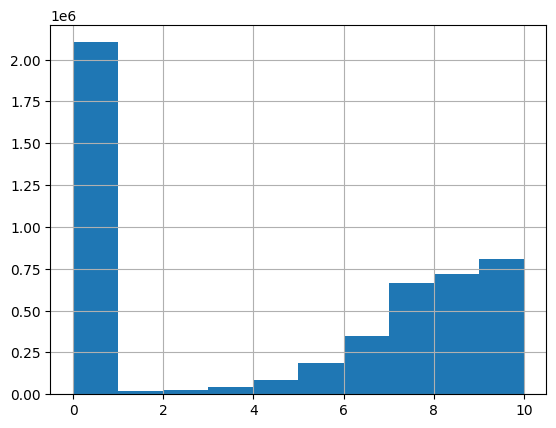

In [107]:
rating_df["rating"].hist()

In [108]:
n_ratings = rating_df["user_id"].value_counts()
# print(n_ratings)
print(len(n_ratings))
# Filter rating_df to keep only users who have rated at least 400 animes.
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=100].index)].copy()
print(rating_df.shape)

15186
(4816175, 3)


In [109]:
len(rating_df)

4816175

In [110]:
min_rating =min(rating_df["rating"])
max_rating =max(rating_df["rating"])
print(min_rating)
print(max_rating)

0
10


In [111]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(4.271538305813223)

In [112]:
scale_rating = MinMaxScaler()
rating_df["rating"] = scale_rating.fit_transform(rating_df[["rating"]])

In [114]:
rating_df.head()

,user_id,anime_id,rating
74,1,37403,0.8
75,1,9989,0.0
76,1,24833,0.0
77,1,7674,0.7
78,1,34572,0.0


In [115]:
rating_df.duplicated().sum()


np.int64(0)

In [118]:
# encoding user id and creating new user column that maps the encoded user_id
encoding_user = LabelEncoder()

rating_df["user"] = encoding_user.fit_transform(rating_df["user_id"])
rating_df.sample(5)

,user_id,anime_id,rating,user
3745040,12411,35241,1.0,8286
2494980,8358,14675,0.0,5586
3042211,10255,9751,0.7,6814
4160290,13720,379,1.0,9200
2558139,8574,15451,0.9,5725


In [119]:
encoding_anime = LabelEncoder()
rating_df["anime"] = encoding_anime.fit_transform(rating_df["anime_id"])
rating_df.sample(5)

,user_id,anime_id,rating,user,anime
1976261,6736,8937,0.8,4476,5576
3080835,10364,6325,0.0,6893,4553
515140,1682,22199,0.0,1129,8623
71794,255,4722,0.0,165,3793
4215434,13904,20507,0.0,9327,8290


In [124]:
user_data = rating_df.loc[rating_df["user"] == 3486] 
user_data

,user_id,anime_id,rating,user,anime
1519499,5247,42514,0.0,3486,16645
1519500,5247,40850,0.0,3486,16066
1519501,5247,40623,0.0,3486,15934
1519502,5247,38145,0.0,3486,14536
1519503,5247,38671,0.0,3486,14817
...,...,...,...,...,...
1520186,5247,890,0.0,3486,805
1520187,5247,1382,0.0,3486,1251
1520188,5247,763,0.0,3486,698
1520189,5247,36999,0.0,3486,13781


In [125]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [127]:
print(len(X_train))
print(len(X_test))
print(type(X_train))

3852940
963235
<class 'numpy.ndarray'>


In [128]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [129]:
type(X_test_array)

list

In [132]:
n_users = rating_df["user"].nunique()
n_users

11110

In [134]:
n_anime = rating_df["anime"].nunique()
n_anime

17158

### Model Architecture

In [139]:
def RecommenderNet():
    embedding_size = 128
    user = Input(name="user", shape = [1])
    user_embedding = Embedding(name="user_embedding",
                               input_dim = n_users,
                               output_dim = embedding_size
                               )(user)
    
    anime = Input(name = "anime", shape=[1])

    anime_embedding = Embedding(
        name="anime_embedding",
        input_dim = n_anime,
        output_dim = embedding_size
    )(anime)

    x = Dot(name="dot_product",
            normalize = True,
            axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)

    x = Dense(1, kernel_initializer="he_normal")(X)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs= [user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=["mae", "mse"],
                  optimizer = "Adam")
    return model

In [140]:
model = RecommenderNet()

ValueError: Unrecognized keyword arguments passed to Model: {'inputs': [<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=user>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=anime>], 'output': <tf.Tensor: shape=(4816175, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)>}